In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import warnings
warnings.filterwarnings("ignore")

def get_res_df(reports_path, sendrates):
    frames_all = []
    for rate in sendrates:
        frames = []
        for i in range(1,6):
            filename = 'report-{}-{}.html'.format(rate, i)
            df = pd.read_html(join(reports_path, filename), flavor='bs4')[0]
            frames.append(df)
        df_concated = pd.concat(frames)
        df_mean = df_concated.groupby('Name').mean()
        df_mean['Rate'] = rate
        frames_all.append(df_mean)
    df_res = pd.concat(frames_all)
    return df_res

def plot_without_real_sendrate(df_res):
    openTPS = df_res[df_res.index=='open']['Throughput (TPS)'].values
    queryTPS = df_res[df_res.index=='query']['Throughput (TPS)'].values
    transferTPS = df_res[df_res.index=='transfer']['Throughput (TPS)'].values

    openLatency = df_res[df_res.index=='open']['Avg Latency (s)'].values
    queryLatency = df_res[df_res.index=='query']['Avg Latency (s)'].values
    transferLatency = df_res[df_res.index=='transfer']['Avg Latency (s)'].values

    fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    axs[0].plot(sendrates, openTPS, label='open', marker='*')
    axs[0].plot(sendrates, queryTPS, label='query', marker='d')
    axs[0].plot(sendrates, transferTPS, label='transfer', marker='<')
    axs[0].set(title='Besu Throughput under Varying Send Rates', 
        xlabel='Send rate (TPS)', ylabel='Throughput (TPS)')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(sendrates, openLatency, label='open', marker='*')
    axs[1].plot(sendrates, queryLatency, label='query', marker='d')
    axs[1].plot(sendrates, transferLatency, label='transfer', marker='<')
    axs[1].set(title='Besu Latency under Varying Send Rates', 
        xlabel='Send rate (TPS)', ylabel='Latency (S)')
    axs[1].grid()
    axs[1].legend()

def plot_with_real_sendrate(df_res):
    openTPS = df_res[df_res.index=='open']['Throughput (TPS)'].values
    openSendRate = df_res[df_res.index=='open']['Send Rate (TPS)'].values
    queryTPS = df_res[df_res.index=='query']['Throughput (TPS)'].values
    querySendRate = df_res[df_res.index=='query']['Send Rate (TPS)'].values
    transferTPS = df_res[df_res.index=='transfer']['Throughput (TPS)'].values
    transferSendRate = df_res[df_res.index=='transfer']['Send Rate (TPS)'].values

    openLatency = df_res[df_res.index=='open']['Avg Latency (s)'].values
    queryLatency = df_res[df_res.index=='query']['Avg Latency (s)'].values
    transferLatency = df_res[df_res.index=='transfer']['Avg Latency (s)'].values

    fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    axs[0].plot(sendrates, openTPS, label='open', marker='*')
    axs[0].plot(sendrates, openSendRate, 'y--', label='open send rate', marker='*')
    axs[0].plot(sendrates, queryTPS, label='query', marker='d')
    axs[0].plot(sendrates, querySendRate, 'y--', label='query send rate', marker='d')
    axs[0].plot(sendrates, transferTPS, label='transfer', marker='<')
    axs[0].plot(sendrates, transferSendRate, 'y--', label='transfer send rate', marker='<')
    axs[0].set(title='Besu Throughput under Varying Send Rates', 
        xlabel='Send rate (TPS)', ylabel='Throughput (TPS)')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(sendrates, openLatency, label='open', marker='*')
    axs[1].plot(sendrates, queryLatency, label='query', marker='d')
    axs[1].plot(sendrates, transferLatency, label='transfer', marker='<')
    axs[1].set(title='Besu Latency under Varying Send Rates', 
        xlabel='Send rate (TPS)', ylabel='Latency (S)')
    axs[1].grid()
    axs[1].legend()

In [5]:
path = '../caliper-benchmarks/reports'
sendrates = np.arange(40,240,40)
df_res = get_res_df(path, sendrates) 
df_res

,Succ,Fail,Send Rate (TPS),Max Latency (s),Min Latency (s),Avg Latency (s),Throughput (TPS),Rate
Name,,,,,,,,
open,1000.0,0.0,37.36,8.398,0.872,3.766,32.74,40
query,1000.0,0.0,39.60,0.474,0.030,0.060,39.56,40
transfer,1000.0,0.0,39.88,5.328,0.750,2.658,36.58,40
open,1000.0,0.0,67.68,11.548,1.954,6.002,49.78,80
query,1000.0,0.0,79.14,0.578,0.018,0.076,78.84,80
transfer,1000.0,0.0,56.58,19.504,1.104,9.362,31.22,80
open,1000.0,0.0,95.46,17.864,1.052,8.480,41.26,120
query,1000.0,0.0,118.14,0.450,0.022,0.082,117.36,120
transfer,1000.0,0.0,118.62,22.350,1.714,11.846,39.46,120


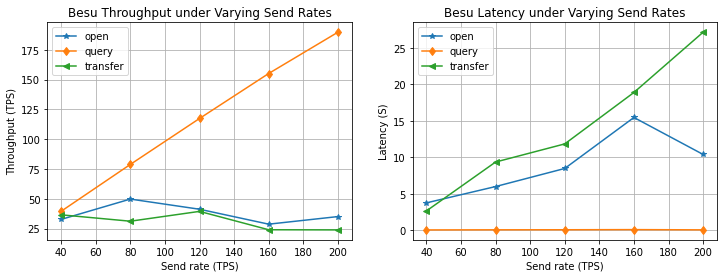

In [6]:
plot_without_real_sendrate(df_res)

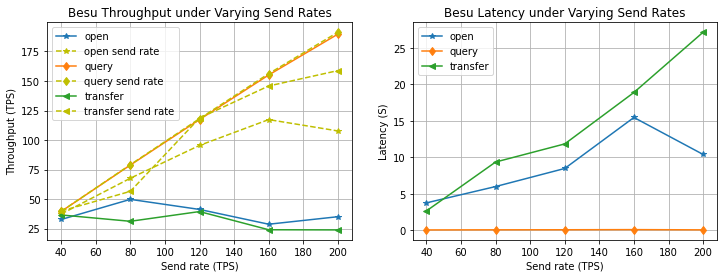

In [7]:
plot_with_real_sendrate(df_res)

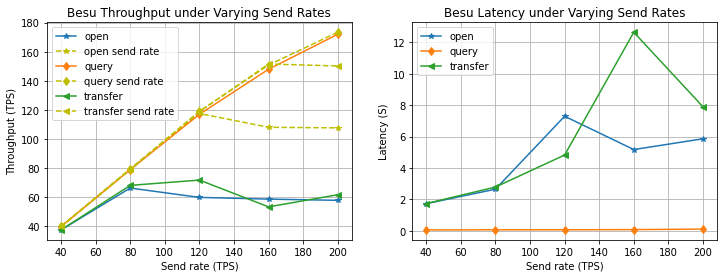

In [8]:
path_reports_4nodes = '../caliper-benchmarks/reports-20211021-154623'
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

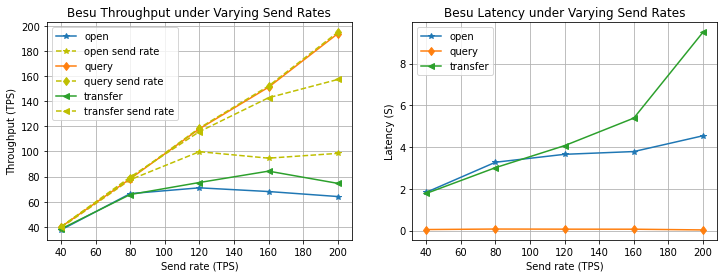

In [9]:
path_reports_4nodes = '../caliper-benchmarks/reports-20211021-165809'
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

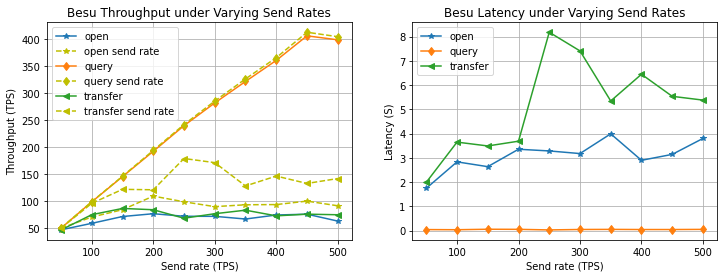

In [10]:
path_reports_4nodes = '../caliper-benchmarks/reports-20211022-095931'
sendrates = np.arange(50, 550, 50)
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

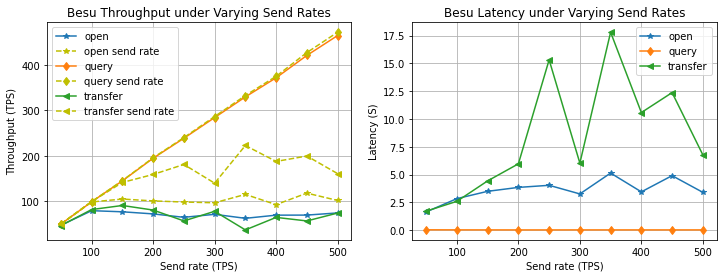

In [23]:
path_reports_4nodes = '../caliper-benchmarks/reports-20211022-171023'
sendrates = np.arange(50, 550, 50)
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

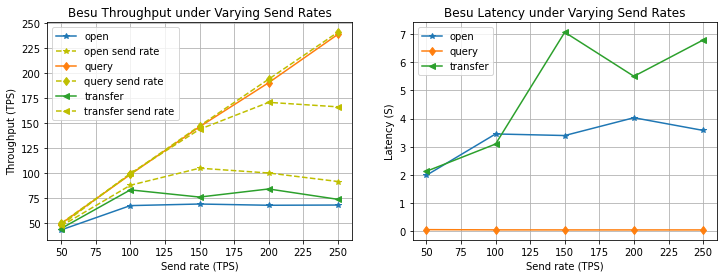

In [12]:
path_reports_4nodes = '../caliper-benchmarks/reports-20211119-105937'
sendrates = np.arange(50, 300, 50)
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

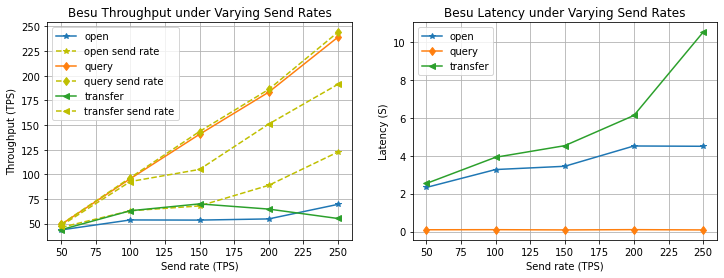

In [2]:
# 4 vcpu 15 gram
path_reports_4nodes = '../caliper-benchmarks/reports-20211129-152024'
sendrates = np.arange(50, 300, 50)
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

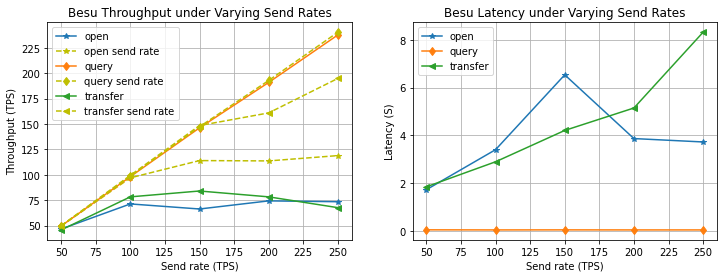

In [3]:
# 8u30g
path_reports_4nodes = '../caliper-benchmarks/reports-20211130-140232'
sendrates = np.arange(50, 300, 50)
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

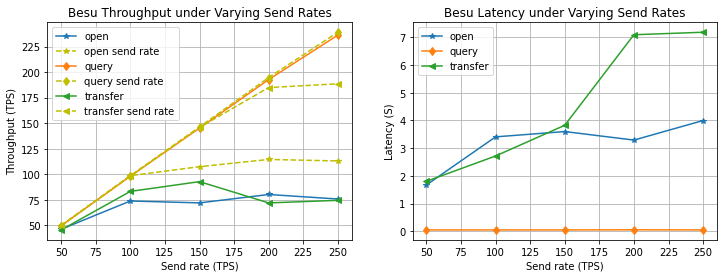

In [4]:
# 16u60gram
path_reports_4nodes = '../caliper-benchmarks/reports-20211130-162538'
sendrates = np.arange(50, 300, 50)
df_res = get_res_df(path_reports_4nodes, sendrates)
plot_with_real_sendrate(df_res)

In [4]:
path_reports_4nodes_1 = '../caliper-benchmarks/reports-20211129-152024'
path_reports_4nodes_2 = '../caliper-benchmarks/reports-20211130-140232'
path_reports_4nodes_3 = '../caliper-benchmarks/reports-20211130-162538'
sendrates = np.arange(50, 300, 50)
df_res_1 = get_res_df(path_reports_4nodes_1, sendrates)
df_res_2 = get_res_df(path_reports_4nodes_2, sendrates)
df_res_3 = get_res_df(path_reports_4nodes_3, sendrates)

In [10]:
sendrates

array([ 50, 100, 150, 200, 250])

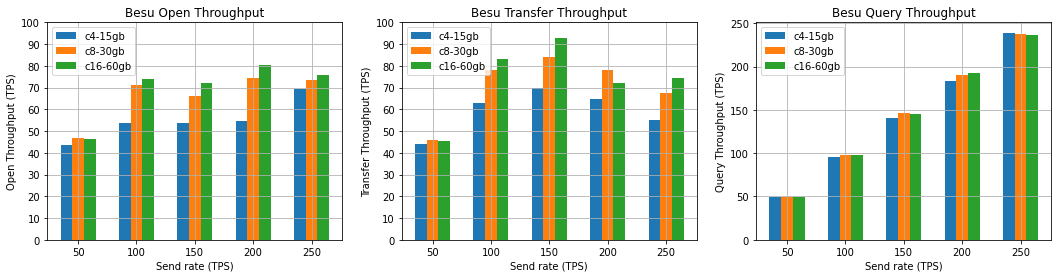

In [33]:
openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label='c4-15gb')
axs[0].bar(X_axis, openTPS_2, 0.2, label='c8-30gb')
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label='c16-60gb')
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label='c4-15gb')
axs[1].bar(X_axis, transferTPS_2, 0.2, label='c8-30gb')
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label='c16-60gb')
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label='c4-15gb')
axs[2].bar(X_axis, queryTPS_2, 0.2, label='c8-30gb')
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label='c16-60gb')
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')


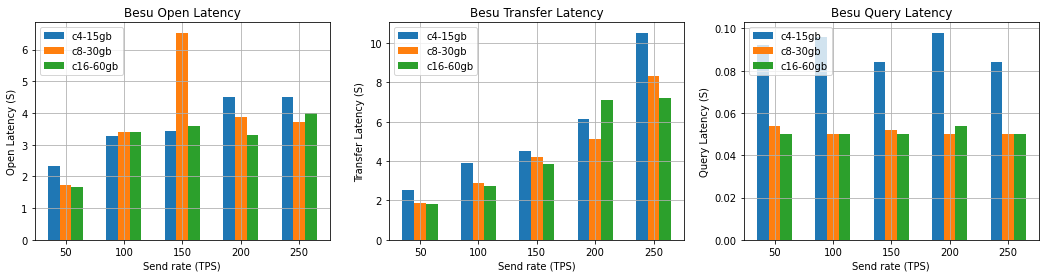

In [37]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label='c4-15gb')
axs[0].bar(X_axis, openLatency_2, 0.2, label='c8-30gb')
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label='c16-60gb')
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label='c4-15gb')
axs[1].bar(X_axis, transferLatency_2, 0.2, label='c8-30gb')
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label='c16-60gb')
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label='c4-15gb')
axs[2].bar(X_axis, queryLatency_2, 0.2, label='c8-30gb')
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label='c16-60gb')
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')


In [96]:
import csv
def log2csv(log_file: str):
    with open(log_file, 'r') as file:
        lines = file.read().splitlines()
        csv_lines = [x.split(' | ') for x in lines]
        csv_file = log_file.replace('.log', '.csv')
        with open(csv_file, 'w+') as csv_file:
            w = csv.writer(csv_file)
            w.writerows(csv_lines)

In [99]:
log_file = '../data/besu-debug-1.log'
log2csv(log_file)

In [105]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')


def parse_log(log_file: str) -> pd.DataFrame:
    csv_file = log_file.replace('.log', '.csv')
    header = ['Timestamp', 'Process', 'LogLevel', 'LogSource', 'Description']
    df_besu = pd.read_csv(csv_file, parse_dates=['Timestamp'], names=header).dropna()
    df_besu['Timestamp'] = pd.to_datetime(df_besu.Timestamp, infer_datetime_format=True, utc=True)
    
    df_ibftround = df_besu[df_besu.LogSource == 'IbftRound']
    df_temp = df_ibftround.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)
    df_ibftround.loc[:, 'Action'] = df_temp[0].values
    df_ibftround.loc[:, 'Order'] = df_temp[1].values
    df_des = df_ibftround.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df_ibftround.loc[:, 'Sequence'] = df_des[0].values
    df_ibftround.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].values

    df_ibftround.reset_index(inplace=True)
    df_ibftround.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df_ibftround

In [113]:
log_file = '../data/besu-debug-3.log'
df3 = parse_log(log_file)
df3

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round
0,2021-12-09 23:18:17.502000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a proposal message,1,4
1,2021-12-09 23:18:17.516000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending prepare message,1,4
2,2021-12-09 23:18:17.533000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1,4
3,2021-12-09 23:18:17.533000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,1,4
4,2021-12-09 23:18:17.538000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,1,4
...,...,...,...,...,...,...,...
48870,2021-12-10 02:46:33.007000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,6249,0
48871,2021-12-10 02:46:33.008000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,6249,0
48872,2021-12-10 02:46:33.008000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,6249,0
48873,2021-12-10 02:46:33.009000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,6249,0


In [108]:
log_file = '../data/besu-debug-2.log'
df2 = parse_log(log_file)
df2

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round
0,2021-12-09 23:18:17.520000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a proposal message,1,4
1,2021-12-09 23:18:17.528000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending prepare message,1,4
2,2021-12-09 23:18:17.537000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1,4
3,2021-12-09 23:18:17.537000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,1,4
4,2021-12-09 23:18:17.543000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1,4
...,...,...,...,...,...,...,...
48759,2021-12-10 02:46:21.005000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,6243,0
48760,2021-12-10 02:46:21.006000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,6243,0
48761,2021-12-10 02:46:21.006000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,6243,0
48762,2021-12-10 02:46:21.007000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,6243,0


In [109]:
log_file = '../data/besu-debug-1.log'
df1 = parse_log(log_file)
df1

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round
0,2021-12-09 23:16:52.087000+00:00,pool-9-thread-1,DEBUG,IbftRound,Creating proposed block,1,0
1,2021-12-09 23:18:17.490000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending proposal with new block,1,4
2,2021-12-09 23:18:17.520000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1,4
3,2021-12-09 23:18:17.528000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1,4
4,2021-12-09 23:18:17.528000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,1,4
...,...,...,...,...,...,...,...
48890,2021-12-10 02:46:01.006000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,6233,0
48891,2021-12-10 02:46:01.007000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,6233,0
48892,2021-12-10 02:46:01.007000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,6233,0
48893,2021-12-10 02:46:01.008000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,6233,0


In [112]:
df2.Timestamp[0] - df1.Timestamp[1]

Timedelta('0 days 00:00:00.030000')

In [114]:
df3.Timestamp[0] - df1.Timestamp[1]

Timedelta('0 days 00:00:00.012000')

In [115]:
np.arange(50, 300, 50)

array([ 50, 100, 150, 200, 250])